# Cross-Entropy Method (CEM) Planner

> Planner using the Cross-Entropy Method (CEM) for optimization of discrete action sequences.

In [ ]:
#| default_exp planners.cem_planner

In [ ]:
# #| hide
# from nbdev.showdoc import *  

In [ ]:
#| export 
from fastcore.utils import *
import pandas as pd
import wandb
import os
from mawm.data.utils import base_tf, msg_tf
import numpy as np

In [ ]:
#| export

import torch
import torch.nn.functional as F
import numpy as np
from einops import rearrange, repeat

class DiscreteCEMPlanner():
    def __init__(
        self,
        horizon,
        topk,
        num_samples,
        opt_steps,
        eval_every,
        wm,
        action_dim, # This is now the number of discrete actions
        objective_fn,
        preprocessor,
        evaluator,
        wandb_run,
        smoothing=0.01, # Laplace smoothing constant
        logging_prefix="plan_discrete",
        log_filename="logs.json",
        **kwargs,
    ):
        super().__init__(
            wm, action_dim, objective_fn, preprocessor, 
            evaluator, wandb_run, log_filename
        )
        self.horizon = horizon
        self.topk = topk
        self.num_samples = num_samples
        self.opt_steps = opt_steps
        self.eval_every = eval_every
        self.smoothing = smoothing
        self.logging_prefix = logging_prefix

    def init_probs(self, obs_0):
        """Initializes a uniform distribution over actions for each timestep."""
        n_evals = obs_0["visual"].shape[0]
        # (Batch, Horizon, Num_Actions) - start with uniform probabilities
        probs = torch.full((n_evals, self.horizon, self.action_dim), 1.0 / self.action_dim)
        return probs

    

In [ ]:
#| export
@patch
def plan(self: DiscreteCEMPlanner, obs_0, obs_g, actions=None):
    self.probs = torch.full((self.horizon, self.action_dim), 1.0/self.action_dim).to(self.device)
    trans_obs_0 = self.preprocessor(obs_0).to(self.device)
    trans_obs_g = self.preprocessor(obs_g).to(self.device)
    
    z_obs_g = self.wm.backbone(trans_obs_g)
    z_obs_g = {f"goal_agent{i}": v for i, v in enumerate(z_obs_g)}
    
    trans_obs_0 = {f"agent{i}": v for i, v in enumerate(trans_obs_0)}

    msgs = {agent: msg_tf((obs_0[agent]['pov'], agent, False)) for agent in self.agents}

    # Initialize probabilities
    probs = self.init_probs(obs_0).to(self.device)
    n_evals = probs.shape[0]

    for i in range(self.opt_steps):
        losses = []
        for traj_idx in range(n_evals):
            # 1. Prepare observations for the current trajectory batch
            cur_trans_obs_0 = {
                key: repeat(arr[traj_idx].unsqueeze(0), "1 ... -> n ...", n=self.num_samples)
                for key, arr in trans_obs_0.items()
            }
            cur_z_obs_g = {
                key: repeat(arr[traj_idx].unsqueeze(0), "1 ... -> n ...", n=self.num_samples)
                for key, arr in z_obs_g.items()
            }

            # 2. Sample discrete actions from the current distribution
            # We flatten to sample, then reshape back
            p = probs[traj_idx] # (H, action_dim)
            # Sample (num_samples) for each step in the horizon
            sampled_indices = torch.multinomial(p, self.num_samples, replacement=True) 
            sampled_indices = sampled_indices.T # (num_samples, H)

            # 3. Rollout in World Model
            # Note: If your WM expects one-hot, convert sampled_indices here
            with torch.no_grad():
                # We pass sampled_indices (integers). Adjust if WM needs one-hot vectors.
                i_z_obses, i_zs = self.wm.forward_multiple(
                    obs_0=cur_trans_obs_0,
                    act=sampled_indices, 
                )

            # 4. Evaluate and find Elites
            loss = self.objective_fn(i_z_obses, cur_z_obs_g)
            topk_idx = torch.argsort(loss)[: self.topk]
            elite_actions = sampled_indices[topk_idx] # (topk, H)

            # 5. Update Distribution (Frequency Counting)
            # Convert elite actions to one-hot: (topk, H, action_dim)
            elite_one_hot = F.one_hot(elite_actions, num_classes=self.action_dim).float()
            
            # Average the one-hots to get new probabilities
            new_probs = elite_one_hot.mean(dim=0) # (H, action_dim)

            # 6. Apply Laplace Smoothing
            # Ensures we don't have 0% probability for any action
            new_probs = (new_probs + self.smoothing) / (1 + self.smoothing * self.action_dim)
            probs[traj_idx] = new_probs

            losses.append(loss[topk_idx[0]].item())

        # Logging logic (same as your original code)
        self.wandb_run.log({f"{self.logging_prefix}/loss": np.mean(losses), "step": i + 1})
        
        if self.evaluator is not None and i % self.eval_every == 0:
            # For evaluation, we pick the most likely action (argmax)
            best_actions = torch.argmax(probs, dim=-1)
            logs, successes, _, _ = self.evaluator.eval_actions(
                best_actions, filename=f"{self.logging_prefix}_output_{i+1}"
            )
            # ... (rest of logging)
            if np.all(successes): break

    # Return the most likely action sequence
    return torch.argmax(probs, dim=-1), np.full(n_evals, np.inf)

In [ ]:
#| hide
from mawm.envs.marl_grid import make_env
from mawm.envs.marl_grid.cfg import config
import copy
import numpy as np

seed = np.random.randint(0, 10000)
cfg = copy.deepcopy(config)
cfg.env_cfg.seed = int(seed)
cfg.env_cfg.max_steps = 512

env = make_env(cfg.env_cfg)
agents = [f"agent_{i}" for i in range(cfg.env_cfg.num_agents)]
obs = env.reset()
goal_pos = obs["global"]["goal_pos"]
goal_obs = np.array([
    env.get_goal(env.agents[i], goal_pos)[0]
    for i in range(config.env_cfg.num_agents)
])

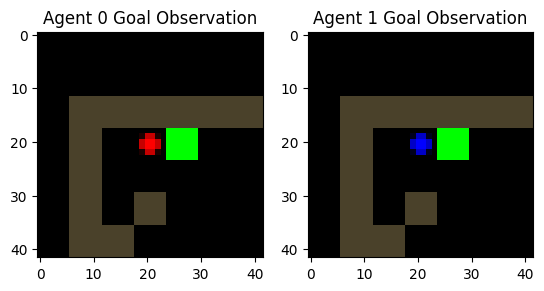

In [ ]:
#| hide
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, cfg.env_cfg.num_agents)
for i in range(cfg.env_cfg.num_agents):
    ax[i].imshow(goal_obs[i])
    ax[i].set_title(f"Agent {i} Goal Observation")
plt.show()

In [ ]:
#|hide
goal_obs.shape

(2, 42, 42, 3)

In [ ]:
#| hide
from mawm.data.utils import base_tf, msg_tf
def preprocessor(obs):
    obs = torch.stack([base_tf(obs[i].astype(np.uint8)) for i in range(len(obs))])
    return obs

In [ ]:
#| hide
import torch
from mawm.data.utils import base_tf, msg_tf
goals = torch.stack([base_tf(goal_obs[i].astype(np.uint8)) for i in range(len(goal_obs))])
goals.shape

torch.Size([2, 3, 42, 42])

In [ ]:
#| hide 
from mawm.models.jepa import JEPA
from omegaconf import OmegaConf
cfg = OmegaConf.load("../cfgs/MPCJepa/mpc.yaml")
model = JEPA(cfg.model, input_dim=(3, 42, 42), action_dim=1)

{'CellEmpty': 0, 'CellObstacle': 1, 'CellItem': 2, 'CellGoal': 3, 'CellAgent': 4, 'GoalAt': 5, 'ItemAt': 6, 'Near': 7, 'SeeGoal': 8, 'CanMove': 9, 'OtherAgentAt': 10, 'OtherAgentNear': 11, 'OtherAgentDirection': 12}


In [ ]:
#| hide
import torch
encoded_goals = model.backbone(goals)
encoded_goals.shape

torch.Size([2, 16, 15, 15])

In [ ]:
#| hide
obs['agent_0'].keys()

dict_keys(['pov', 'selfpos', 'orientation', 'identity'])

In [ ]:
#| hide
obs = env.reset()
goal_obs = np.array([
    env.get_goal(env.agents[i], goal_pos)[0]
    for i in range(config.env_cfg.num_agents)
])
goals = torch.stack([base_tf(goal_obs[i].astype(np.uint8)) for i in range(len(goal_obs))])
encoded_goals = model.backbone(goals)

msgs = {agent: msg_tf((obs[agent]['pov'], agent, False)) for agent in agents}



In [ ]:
#| hide
obs['agent_0']['pov'].astype(np.uint8).shape,  msgs['agent_0'].shape

((42, 42, 3), torch.Size([5, 7, 7]))

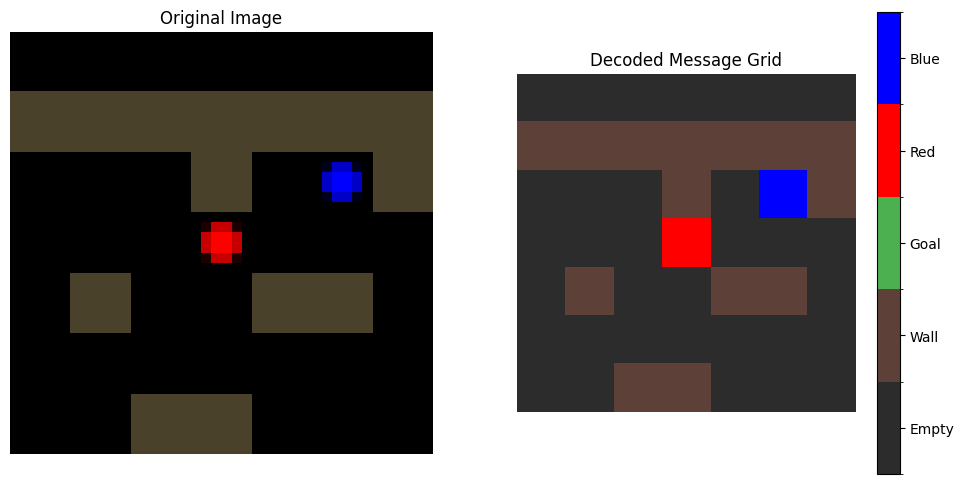

In [ ]:
#| hide
from mawm.data.utils import plot_grid
plot_grid(obs['agent_0']['pov'].astype(np.uint8), msgs['agent_0'].permute(1, 2, 0))

In [ ]:
#| hide
obs_transformed = torch.stack([base_tf(obs[agent]['pov'].astype(np.uint8)) for agent in agents])
encoded_obs = model.backbone(obs_transformed)
encoded_obs.shape

torch.Size([2, 16, 15, 15])

In [ ]:
#| hide
pos = torch.stack([torch.from_numpy(obs[agent]['selfpos']) for agent in agents])
pos.shape

torch.Size([2, 2])

In [ ]:
#| hide
encoded_obs = model.backbone(obs_transformed, position=pos)
encoded_obs.shape

torch.Size([2, 18, 15, 15])

In [ ]:
#| hide
model.backbone.repr_dim

(18, 15, 15)

In [ ]:
#| hide
encoded_goals.shape

torch.Size([2, 16, 15, 15])

In [ ]:
#| hide
from mawm.models.misc import ObsPred, MsgPred
from mawm.models.vision import SemanticEncoder

In [ ]:
#| hide
obs_pred = ObsPred(h_dim=32, out_channels=18)
msg_pred = MsgPred(h_dim=32, in_channels=18)
msg_encoder = SemanticEncoder(latent_dim=32)

In [ ]:
# #| export
# from mawm.models.utils import Expander2D
# class CEMPlanner:
#     def __init__(self, model, msg_enc, msg_pred, obs_pred, 
#                  action_dim= 5, horizon= 10, num_samples= 1000,
#                  num_elites=100, opt_steps=100):
        
#         self.probs = torch.full((horizon, action_dim), 1.0/action_dim) # Uniform initial distribution of shape [Horizon, Action_Dim]
#         self.model = model
#         self.msg_enc = msg_enc
#         self.msg_pred = msg_pred
#         self.obs_pred = obs_pred
#         self.action_dim = action_dim
#         self.horizon = horizon
#         self.num_samples = num_samples
#         self.num_elites = num_elites
#         self.opt_steps = opt_steps
#         self.device = 'cpu'
        

#     def update_dist(self, probs, samples, costs, num_elites=50):

#         values, elite_indices = torch.topk(-costs, num_elites)
#         elites = samples[elite_indices] # [num_elites, Horizon]
        
#         # Update probabilities for the next round
#         new_probs = torch.full_like(probs, 0.01 / probs.shape[-1])
#         for t in range(probs.shape[0]):
#             new_probs[t].scatter_add_(0, elites[:, t], torch.ones(num_elites) * (0.99 / num_elites))
        
#         best_plan = elites[0]
        
#         return new_probs, best_plan


#     @torch.no_grad()
#     def plan(self, o_t, pos_t, o_g, m_other, other_actions):
#         z_t  = self.model.backbone(o_t.unsqueeze(0)) # [B=1, C, H, W] => [1, 16, 15, 15] #, position= pos_t.unsqueeze(0)
#         pos_t = Expander2D(z_t.shape[-1], z_t.shape[-2])(pos_t.unsqueeze(0)) # [1, 2, 15, 15]
#         z_t = torch.cat([z_t, pos_t], dim=1) # [1, 18, 15, 15]
#         z_g = self.model.backbone(o_g.unsqueeze(0)) # [B=1, C, H, W] => [1, 16, 15, 15]

#         a_self = torch.multinomial(self.probs, self.num_samples, replacement=True).T # [num_samples, horizon] 
        
#         h0_other = self.msg_enc(m_other.unsqueeze(0).unsqueeze(1)) # [5, 7, 7] => [1, 1, 32]
#         a_other = other_actions.repeat(self.num_samples, 1) # [num_samples, horizon]

#         total_costs = self.evolve(z_t, z_g, h0_other, a_self, a_other)
#         self.probs, best_plan = self.update_dist(self.probs, a_self, total_costs, self.num_elites)
#         return best_plan

#     def evolve(self, z_t, z_goal, h0_other, a_self, a_other):
#         S = self.num_samples

#         curr_z_self = repeat(z_t, 'b c h w -> (b s) t c h w', b= 1, s=S, t= 1) # [s, t= 1, c=18, h=15, w=15]
#         curr_h_other = repeat(h0_other, 'b t d -> s t (b d)', s=S) # [s, 1, 32]
        
#         curr_z_other = self.obs_pred(curr_h_other)#[s, 1, 16, 15, 15]  
#         curr_h_self = self.msg_pred(curr_z_self[:, :, :-2]) #[s, 1, 32]

#         curr_z_self = rearrange(curr_z_self, "s t c h w -> (t s) c h w", t= 1)
#         curr_z_other = rearrange(curr_z_other, "s t c h w -> (t s) c h w", t= 1)

#         total_cost = torch.zeros(S, device=self.device)
#         # import pdb; pdb.set_trace()
#         for t in range(self.horizon):
            
#             curr_h_other = rearrange(curr_h_other, "s t d -> (t s) d", t= 1)
#             curr_h_self = rearrange(curr_h_self, "s t d -> (t s) d", t= 1)

#             a_self_t = a_self[:, t].unsqueeze(1) # [1 500]
#             a_other_t = a_other[:, t].unsqueeze(1) # [1, 500]
            

#             next_z_self = self.model.dynamics.forward(current_state = curr_z_self, curr_action= a_self_t, curr_msg= curr_h_other)
#             next_z_other = self.model.dynamics.forward(current_state = curr_z_other, curr_action= a_other_t, curr_msg= curr_h_self)

#             next_h_self = self.msg_pred(rearrange(next_z_self[:, :-2], '(s t) c h w -> s t c h w ', t= 1))
#             next_h_other = self.msg_pred(rearrange(next_z_other[:, :-2], '(s t) c h w -> s t c h w ', t= 1))

#             total_cost += (next_z_self[:, :-2] - z_goal.unsqueeze(1)).pow(2).mean(dim=(2, 3, 4)).squeeze()

#             curr_z_self, curr_z_other = next_z_self, next_z_other
#             curr_h_self, curr_h_other = next_h_self, next_h_other

#         return total_cost

In [ ]:
# #| export
# from mawm.models.utils import Expander2D
# import torch
# from einops import repeat, rearrange

# class CEMPlanner:
#     def __init__(self, model, msg_enc, msg_pred, obs_pred, 
#                  action_dim=5, horizon=10, num_samples=1000,
#                  num_elites=100, opt_steps=10): # Reduced opt_steps for speed, adjust as needed
        
#         self.model = model
#         self.msg_enc = msg_enc
#         self.msg_pred = msg_pred
#         self.obs_pred = obs_pred
#         self.action_dim = action_dim
#         self.horizon = horizon
#         self.num_samples = num_samples
#         self.num_elites = num_elites
#         self.opt_steps = opt_steps
#         self.device = 'cpu'
        
#     def update_dist(self, probs, samples, costs, num_elites):
#         # Find indices of samples with the lowest cost
#         # topk on negative costs gives us the minimum values
#         _, elite_indices = torch.topk(-costs, num_elites)
#         elites = samples[elite_indices] # [num_elites, horizon]
        
#         # Create a fresh probability distribution based on elite actions
#         new_probs = torch.zeros_like(probs)
#         for t in range(self.horizon):
#             # Count how often each action appeared in the elite set at time t
#             counts = torch.bincount(elites[:, t], minlength=self.action_dim).float()
#             new_probs[t] = counts / num_elites
        
#         # Apply smoothing (Laplace smoothing) to prevent 0-probability actions
#         # This keeps the distribution "open" for the next opt_step
#         epsilon = 0.01
#         new_probs = (1 - epsilon) * new_probs + (epsilon / self.action_dim)
        
#         best_plan = elites[0]
#         return new_probs, best_plan

#     @torch.no_grad()
#     def plan(self, o_t, pos_t, o_g, m_other, other_actions):
#         # 1. INITIALIZE: Reset distribution to uniform at the start of every plan call
#         # This ensures we don't carry over bias from previous environment steps.
#         current_probs = torch.full((self.horizon, self.action_dim), 1.0/self.action_dim, device=self.device)

#         # 2. ENCODE: Prepare latent states once
#         z_t = self.model.backbone(o_t.unsqueeze(0)) 
#         pos_t_expanded = Expander2D(z_t.shape[-1], z_t.shape[-2])(pos_t.unsqueeze(0))
#         z_t = torch.cat([z_t, pos_t_expanded], dim=1) 
#         z_g = self.model.backbone(o_g.unsqueeze(0)) 
        
#         h0_other = self.msg_enc(m_other.unsqueeze(0).unsqueeze(1)) 
#         # The other agent's plan is treated as a fixed anchor for this optimization cycle
#         a_other = other_actions.repeat(self.num_samples, 1) 

#         # 3. OPTIMIZE: The CEM Loop (Step 'f' in your paper)
#         best_plan = None
#         for _ in range(self.opt_steps):
#             # Sample sequences from current distribution
#             # Shape: [num_samples, horizon]
#             a_self = torch.multinomial(current_probs, self.num_samples, replacement=True).T 
            
#             # Evaluate samples using the world model
#             total_costs = self.evolve(z_t, z_g, h0_other, a_self, a_other)
            
#             # Update the distribution to focus on low-cost regions
#             current_probs, best_plan = self.update_dist(current_probs, a_self, total_costs, self.num_elites)

#         return best_plan

#     def evolve(self, z_t, z_goal, h0_other, a_self, a_other):
#         S = self.num_samples
#         # ... (Your existing evolve logic remains the same) ...
#         curr_z_self = repeat(z_t, 'b c h w -> (b s) t c h w', b= 1, s=S, t= 1)
#         curr_h_other = repeat(h0_other, 'b t d -> s t (b d)', s=S)
        
#         curr_z_other = self.obs_pred(curr_h_other)  
#         curr_h_self = self.msg_pred(curr_z_self[:, :, :-2]) 

#         curr_z_self = rearrange(curr_z_self, "s t c h w -> (t s) c h w", t= 1)
#         curr_z_other = rearrange(curr_z_other, "s t c h w -> (t s) c h w", t= 1)

#         total_cost = torch.zeros(S, device=self.device)
        
#         for t in range(self.horizon):
#             curr_h_other = rearrange(curr_h_other, "s t d -> (t s) d", t= 1)
#             curr_h_self = rearrange(curr_h_self, "s t d -> (t s) d", t= 1)

#             a_self_t = a_self[:, t].unsqueeze(1) 
#             a_other_t = a_other[:, t].unsqueeze(1) 
            
#             next_z_self = self.model.dynamics.forward(current_state=curr_z_self, curr_action=a_self_t, curr_msg=curr_h_other)
#             next_z_other = self.model.dynamics.forward(current_state=curr_z_other, curr_action=a_other_t, curr_msg=curr_h_self)

#             next_h_self = self.msg_pred(rearrange(next_z_self[:, :-2], '(s t) c h w -> s t c h w ', t= 1))
#             next_h_other = self.msg_pred(rearrange(next_z_other[:, :-2], '(s t) c h w -> s t c h w ', t= 1))

#             # Cost calculation: MSE to goal
#             total_cost += (next_z_self[:, :-2] - z_goal).pow(2).mean(dim=(1, 2, 3))

#             curr_z_self, curr_z_other = next_z_self, next_z_other
#             curr_h_self, curr_h_other = next_h_self, next_h_other

#         return total_cost

{'CellEmpty': 0, 'CellObstacle': 1, 'CellItem': 2, 'CellGoal': 3, 'CellAgent': 4, 'GoalAt': 5, 'ItemAt': 6, 'Near': 7, 'SeeGoal': 8, 'CanMove': 9, 'OtherAgentAt': 10, 'OtherAgentNear': 11, 'OtherAgentDirection': 12}


In [ ]:
# #| export
# from mawm.models.utils import Expander2D
# import torch
# from einops import repeat, rearrange

# class CEMPlanner:
#     def __init__(self, model, msg_enc, msg_pred, obs_pred, 
#                  action_dim=5, horizon=10, num_samples=1000,
#                  num_elites=100, opt_steps=10):
        
#         self.model = model
#         self.msg_enc = msg_enc
#         self.msg_pred = msg_pred
#         self.obs_pred = obs_pred
#         self.action_dim = action_dim # Number of discrete choices (0-4)
#         self.horizon = horizon
#         self.num_samples = num_samples
#         self.num_elites = num_elites
#         self.opt_steps = opt_steps
#         self.device = 'cpu'
        
#     def update_dist(self, probs, samples, costs, num_elites):
#         # We want to MINIMIZE cost, so we take the topk of negative costs
#         _, elite_indices = torch.topk(-costs, num_elites)
#         elites = samples[elite_indices] # [num_elites, horizon]
        
#         new_probs = torch.zeros_like(probs)
#         for t in range(self.horizon):
#             counts = torch.bincount(elites[:, t], minlength=self.action_dim).float()
#             new_probs[t] = counts / num_elites
        
#         # Laplace smoothing to ensure we always have some exploration noise
#         epsilon = 0.01
#         new_probs = (1 - epsilon) * new_probs + (epsilon / self.action_dim)
        
#         return new_probs, elites[0]

#     @torch.no_grad()
#     def plan(self, o_t, pos_t, o_g, m_other, other_actions):
#         # RESET: Start fresh so we don't get stuck in a local minimum from the last step
#         current_probs = torch.full((self.horizon, self.action_dim), 1.0/self.action_dim, device=self.device)

#         z_t = self.model.backbone(o_t.unsqueeze(0)) 
#         pos_t_expanded = Expander2D(z_t.shape[-1], z_t.shape[-2])(pos_t.unsqueeze(0))
#         z_t = torch.cat([z_t, pos_t_expanded], dim=1) 
#         z_g = self.model.backbone(o_g.unsqueeze(0)) 
        
#         h0_other = self.msg_enc(m_other.unsqueeze(0).unsqueeze(1)) 
#         a_other = other_actions.repeat(self.num_samples, 1) 

#         best_plan = None
#         for i in range(self.opt_steps):
#             # Sample sequences: [num_samples, horizon]
#             a_self = torch.multinomial(current_probs, self.num_samples, replacement=True).T 
            
#             total_costs = self.evolve(z_t, z_g, h0_other, a_self, a_other)
            
#             # DEBUG: Uncomment this to see if costs are actually changing
#             if i == 0: print(f"Cost Std: {total_costs.std():.6f}, Min: {total_costs.min():.4f}")

#             current_probs, best_plan = self.update_dist(current_probs, a_self, total_costs, self.num_elites)

#         return best_plan

#     def evolve(self, z_t, z_goal, h0_other, a_self, a_other):
#         S = self.num_samples
        
#         # Ensure z_goal is ready for broadcasting: [1, C, H, W]
#         # We strip the last 2 channels if your goal doesn't include the pos_t expansion
#         z_goal_target = z_goal 

#         curr_z_self = repeat(z_t, 'b c h w -> (b s) c h w', s=S)
#         curr_h_other = repeat(h0_other, 'b t d -> (s b t) d', s=S)
        
#         # Initial imagined states for the other agent
#         curr_z_other = rearrange(self.obs_pred(curr_h_other.unsqueeze(1)), "s t c h w -> (s t) c h w")
#         curr_h_self = self.msg_pred(curr_z_self[:, :-2].unsqueeze(1)).squeeze(1)

#         total_cost = torch.zeros(S, device=self.device)
        
#         for t in range(self.horizon):
#             a_self_t = a_self[:, t].unsqueeze(1) # [S, 1]
#             a_other_t = a_other[:, t].unsqueeze(1) # [S, 1]
            
#             # Forward dynamics
#             next_z_self = self.model.dynamics.forward(current_state=curr_z_self, curr_action=a_self_t, curr_msg=curr_h_other)
#             next_z_other = self.model.dynamics.forward(current_state=curr_z_other, curr_action=a_other_t, curr_msg=curr_h_self)

#             # Predict next messages
#             curr_h_self = self.msg_pred(next_z_self[:, :-2].unsqueeze(1)).squeeze(1)
#             curr_h_other = self.msg_pred(next_z_other[:, :-2].unsqueeze(1)).squeeze(1)

#             # --- CRITICAL: Cost calculation ---
#             # Compare only the latent state (excluding position channels if necessary)
#             # next_z_self[:, :-2] is [S, 16, 15, 15]
#             # z_goal_target is [1, 16, 15, 15]
#             diff = next_z_self[:, :-2] - z_goal_target
            
#             # Step-wise cost (MSE)
#             total_cost += diff.pow(2).mean(dim=(1, 2, 3))

#             curr_z_self, curr_z_other = next_z_self, next_z_other

#         return total_cost

In [ ]:
#| export
import torch
from einops import repeat, rearrange
from mawm.models.utils import Expander2D

class CEMPlanner:
    def __init__(self, model, msg_enc, msg_pred, obs_pred, 
                 action_dim=5, horizon=10, num_samples=1000,
                 num_elites=100, opt_steps=10, device='cpu'):
        
        self.model = model
        self.msg_enc = msg_enc
        self.msg_pred = msg_pred
        self.obs_pred = obs_pred
        self.action_dim = action_dim
        self.horizon = horizon
        self.num_samples = num_samples
        self.num_elites = num_elites
        self.opt_steps = opt_steps
        self.device = device
        
        # Hyperparameters for improved stability
        self.alpha = 0.3  # Momentum for distribution update
        self.epsilon = 0.01  # Laplace smoothing
        self.temp_start = 1.0  # Initial temperature
        self.temp_end = 0.5  # Final temperature
        
    def update_dist(self, probs, samples, costs, num_elites, iteration):
        """Update probability distribution using elite samples with momentum."""
        # Select elites (minimize cost)
        _, elite_indices = torch.topk(-costs, num_elites)
        elites = samples[elite_indices]
        
        # Compute empirical distribution from elites
        empirical_probs = torch.zeros_like(probs)
        for t in range(self.horizon):
            counts = torch.bincount(elites[:, t], minlength=self.action_dim).float()
            empirical_probs[t] = counts / num_elites
        
        # Momentum update for stability
        new_probs = self.alpha * empirical_probs + (1 - self.alpha) * probs
        
        # Laplace smoothing
        new_probs = (1 - self.epsilon) * new_probs + (self.epsilon / self.action_dim)
        
        # Temperature annealing for sharpening
        temp = self.temp_start + (self.temp_end - self.temp_start) * (iteration / self.opt_steps)
        new_probs = new_probs ** (1 / temp)
        new_probs = new_probs / new_probs.sum(dim=1, keepdim=True)
        
        return new_probs, elites[0]

    @torch.no_grad()
    def plan(self, o_t, o_g, pos_t, m_other, other_actions):
        """Plan action sequence using CEM."""
        # Move inputs to device
        o_t = o_t.to(self.device)
        o_g = o_g.to(self.device)
        pos_t = pos_t.to(self.device)
        m_other = m_other.to(self.device)
        other_actions = other_actions.to(self.device)
        
        # Initialize uniform distribution
        current_probs = torch.full(
            (self.horizon, self.action_dim), 
            1.0 / self.action_dim, 
            device=self.device
        )

        # Encode current state and goal
        z_t = self.model.backbone(o_t.unsqueeze(0))
        pos_t_expanded = Expander2D(z_t.shape[-1], z_t.shape[-2])(pos_t.unsqueeze(0))
        z_t = torch.cat([z_t, pos_t_expanded], dim=1)
        
        z_g = self.model.backbone(o_g.unsqueeze(0))
        # Match dimensions with cost calculation (exclude position channels)
        z_goal_target = z_g#[:, :-2]
        
        # Encode other agent's message
        h0_other = self.msg_enc(m_other.unsqueeze(0).unsqueeze(1))
        a_other = other_actions.repeat(self.num_samples, 1)

        best_plan = None
        best_cost = float('inf')
        
        for i in range(self.opt_steps):
            # Sample action sequences
            a_self = torch.multinomial(
                current_probs, 
                self.num_samples, 
                replacement=True
            ).T.to(self.device)
            
            # Evaluate sampled sequences
            total_costs = self.evolve(z_t, z_goal_target, h0_other, a_self, a_other)
            
            # Track best solution
            min_cost = total_costs.min()
            if min_cost < best_cost:
                best_cost = min_cost
                best_idx = total_costs.argmin()
                best_plan = a_self[best_idx]
            
            # Debug info
            if i == 0 or i == self.opt_steps - 1:
                print(f"Iter {i}: Cost μ={total_costs.mean():.4f}, "
                      f"Std={total_costs.std():.4f}, min={min_cost:.4f}")

            # Update distribution
            current_probs, _ = self.update_dist(
                current_probs, a_self, total_costs, self.num_elites, i
            )

        return best_plan

    def evolve(self, z_t, z_goal, h0_other, a_self, a_other):
        """Roll out trajectories and compute costs."""
        S = self.num_samples
        
        # Initialize states
        curr_z_self = repeat(z_t, 'b c h w -> (b s) c h w', s=S)
        curr_h_other = repeat(h0_other, 'b t d -> (s b t) d', s=S)
        
        curr_z_other = rearrange(
            self.obs_pred(curr_h_other.unsqueeze(1)), 
            "s t c h w -> (s t) c h w"
        )
        curr_h_self = self.msg_pred(curr_z_self[:, :-2].unsqueeze(1)).squeeze(1)

        total_cost = torch.zeros(S, device=self.device)
        
        # Roll out trajectories
        for t in range(self.horizon):
            a_self_t = a_self[:, t].unsqueeze(1)
            a_other_t = a_other[:, t].unsqueeze(1)
            
            # Forward dynamics
            next_z_self = self.model.dynamics.forward(
                current_state=curr_z_self, 
                curr_action=a_self_t, 
                curr_msg=curr_h_other
            )
            next_z_other = self.model.dynamics.forward(
                current_state=curr_z_other, 
                curr_action=a_other_t, 
                curr_msg=curr_h_self
            )

            # Update messages
            curr_h_self = self.msg_pred(next_z_self[:, :-2].unsqueeze(1)).squeeze(1)
            curr_h_other = self.msg_pred(next_z_other[:, :-2].unsqueeze(1)).squeeze(1)

            # Compute step cost (MSE to goal)
            diff = next_z_self[:, :-2] - z_goal
            step_cost = diff.pow(2).mean(dim=(1, 2, 3))
            
            # Weight final timestep more heavily
            weight = 2.0 if t == self.horizon - 1 else 1.0
            total_cost += weight * step_cost

            curr_z_self, curr_z_other = next_z_self, next_z_other

        return total_cost

In [ ]:
#| hide
planner = CEMPlanner(model=model, msg_enc= msg_encoder, msg_pred=msg_pred, obs_pred=obs_pred)

In [ ]:
#| hide
torch.manual_seed(0)
probs_j = torch.full((planner.horizon, planner.action_dim), 1.0/planner.action_dim)
other_actions = torch.multinomial(probs_j, 1).squeeze(-1)  # [Horizon]

In [ ]:
other_actions

tensor([2, 0, 1, 4, 0, 4, 0, 0, 1, 3])

In [ ]:
# #| hide
# from einops import rearrange, repeat
# planner.plan(obs_transformed[0], pos[0], o_g=goals[0], m_other=msgs['agent_0'], other_actions=other_actions)

T =  0
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
T =  1
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
T =  2
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
T =  3
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
T =  4
torch.Size([1000, 1]) torch.Size([1000, 32]) torch.Size([1000, 18, 15, 15])
torch.Size([1000, 18, 15, 15])
to

tensor([4, 4, 3, 0, 3, 4, 0, 0, 1, 4])

In [ ]:
#| hide
import nbdev
nbdev.nbdev_export() # type: ignore  # noqa: E702
